lots of centrality analysis
goal: comparison analysis on bots' and regular users' network, to find difference as features in the future

data description: for each comments, link_id is the id of the post that the comment was made in, and parent_id is the id of the comment that the comment is responding to. Subreddit is the name of the subreddit (reddit community) that the post was posted in.

In [87]:
import pandas as pd
user_df = pd.read_csv("user_comments.csv")
print(user_df.head())

       author  created_utc    link_id   parent_id  score       id subreddit
0     Inshapo   1535781736  t3_9ajgfw  t1_e56nj07      1  e57777s        de
1  haferkeks2   1535790833  t3_9ajgfw  t1_e56ncfy      1  e57bng5        de
2      step21   1535834519  t3_9b1w1d  t1_e50sqaf      1  e58bx5b        de
3   huetehund   1535836066  t3_9bagae  t1_e53hn9d      1  e58djnt        de
4   [deleted]   1535795742  t3_9bagae  t1_e564if6      1  e57drbo        de


In [88]:
import glob
allFiles = glob.glob("bot_comments" + "*.csv")
bot_df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    if "1" in file_:
        df = pd.read_csv(file_,index_col = None, header = None)
    else:
        df = pd.read_csv(file_,index_col = None, header = None)
    list_.append(df)
bot_df = pd.concat(list_)
bot_df.columns = ['author', 'created_utc', 'link_id', 'parent_id', 'score', 'id','subreddit']
bot_df = bot_df[bot_df['author'] != "author"]

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


###### build network (regular users and bots all inside)

In [53]:
#if user respond to a same comment, then we linked then together, build the graph
comment_map_user = {} #comment_id, #user_name 
for index, row in user_df.iterrows():
    comment_id = row['id']
    comment_map_user[comment_id] = row['author']

In [54]:
#if user respond to a same comment, then we linked then together, build the graph
comment_map_bot = {} #comment_id, #user_name 
for index, row in bot_df.iterrows():
    comment_id = row['id']
    comment_map_bot[comment_id] = row['author']

In [55]:
network_map = {} # key from user, value {key to user, value counts}
for index, row in user_df.iterrows():
    comment_id = row['id']
    respond_id = row['parent_id'].split("_")[1]
    from_user = comment_map_user[comment_id]
    if respond_id in comment_map_user:
        to_user = comment_map_user[respond_id]
    elif respond_id in comment_map_bot:
        to_user = comment_map_bot[respond_id]
    else:
        continue
    if from_user not in network_map:
        network_map[from_user] = {}
    if to_user not in network_map[from_user]:
        network_map[from_user][to_user] = 0
    network_map[from_user][to_user] += 1

In [56]:
for index, row in bot_df.iterrows():
    comment_id = row['id']
    respond_id = row['parent_id'].split("_")[1]
    from_user = comment_map_bot[comment_id]
    if respond_id in comment_map_user:
        to_user = comment_map_user[respond_id]
    elif respond_id in comment_map_bot:
        to_user = comment_map_bot[respond_id]
    else:
        continue
    if from_user not in network_map:
        network_map[from_user] = {}
    if to_user not in network_map[from_user]:
        network_map[from_user][to_user] = 0
    network_map[from_user][to_user] += 1

In [57]:
import json
with open('network.json', 'w') as fp:
    json.dump(network_map, fp)

In [106]:
import networkx as nx
g = nx.DiGraph()
for key, value in network_map.items():
    from_user = key
    for k, v in value.items():
        to_user = k
        weight = v
        g.add_edge(from_user, to_user, weight = weight)

In [96]:
user_list =  user_df['author'].unique().tolist()
bot_list =  bot_df['author'].unique().tolist()

In [92]:
#load network data
import json
with open("network.json") as f_in:
    network_map = json.load(f_in)
f_in.close()

##### degree for users and bots

In [107]:
degree_all = nx.degree_centrality(g)
degree_user = {}
degree_bot = {}
for k, v in degree_all.items():
    if k in bot_list:
        degree_bot[k] = v
    else:
        degree_user[k] = v

In [108]:
import json
with open('degree_bot.json', 'w') as fp:
    json.dump(degree_bot, fp)
fp.close()

with open('degree_user.json', 'w') as fp:
    json.dump(degree_user, fp)
fp.close()

##### visualization analysis 

###### distribution of degree centrality for users and bots

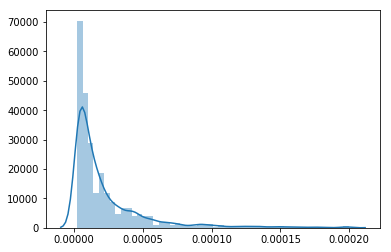

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot([v for v in list(degree_bot.values()) if v < 0.0002])

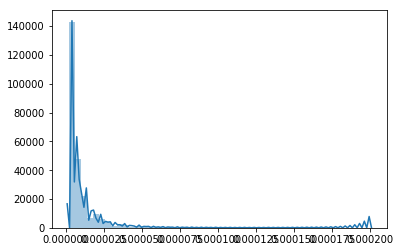

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot([v for v in list(degree_user.values()) if v < 0.0002])

##### times a user to comments and bot to comments
##### times a user get commented and bot get commented

In [97]:
user_to_comment = {} #key user, value times to comments
bot_to_comment = {}
user_get_comment = {}
bot_get_comment = {}
for k, v in network_map.items():
    from_user = k
    for key, value in v.items():
        to_user = key
        times = value
        if from_user in bot_list:
            if from_user not in bot_to_comment:
                bot_to_comment[from_user] = 0
            bot_to_comment[from_user] += times
        else:
            if from_user not in user_to_comment:
                user_to_comment[from_user] = 0
            user_to_comment[from_user] += times
        if to_user in bot_list:
            if to_user not in bot_get_comment:
                bot_get_comment[to_user] = 0
            bot_get_comment[to_user] += times
        else:
            if to_user not in user_get_comment:
                user_get_comment[to_user] = 0
            user_get_comment[to_user] += times

In [98]:
import json
with open('user_get_comment.json', 'w') as fp:
    json.dump(user_get_comment, fp)
fp.close()

with open('user_to_comment.json', 'w') as fp:
    json.dump(user_to_comment, fp)
fp.close()

with open('bot_get_comment.json', 'w') as fp:
    json.dump(bot_get_comment, fp)
fp.close()

with open('bot_to_comment.json', 'w') as fp:
    json.dump(bot_to_comment, fp)
fp.close()

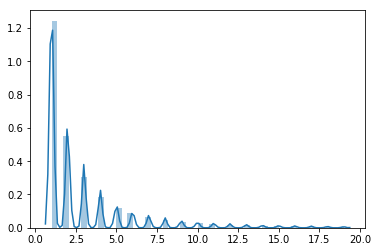

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot([v for v in list(user_get_comment.values()) if v < 20])

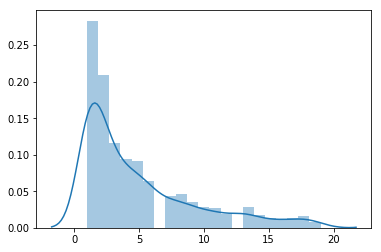

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot([v for v in list(bot_get_comment.values()) if v < 20])

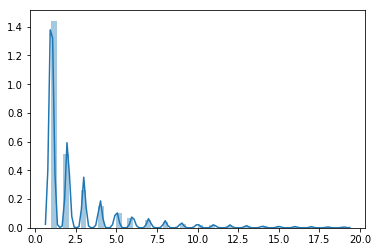

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot([v for v in list(user_to_comment.values()) if v < 20])

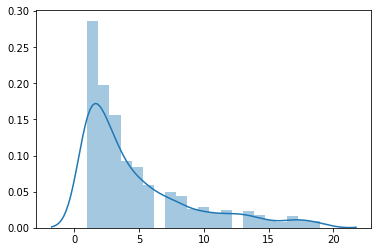

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot([v for v in list(bot_to_comment.values()) if v < 20])